In [1]:
import sys
from time import time
import numpy as np
import pandas as pd
from pathlib import Path
import lightgbm as lgb
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
import copy
import wandb
from collections import OrderedDict

from sklearn.metrics import mean_absolute_error
from sklearn import model_selection
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as torchdata

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger


In [2]:
sys.path.append('../../src/')
import utils as utils
from utils import Timer

In [3]:
class CFG:
    seed = 42
    exp_num = 20
    local = True
    n_folds = 5
    folds = [0]
    debug = False
    bias = 1000
    epochs = 200

    
    ######################
    # Dataset #
    ######################
    transforms = {
        "train": [{"name": ""}],
        "valid": [{"name": ""}],
        "test": [{"name": ""}]
    }

    ######################
    # Loaders #
    ######################
    loader_params = {
        "train": {
            'batch_size': 128,
            'shuffle': True,
            'num_workers': 8,
            'pin_memory': True,
            'drop_last': True,
        },
        "valid": {
            'batch_size': 32,
            'shuffle': False,
            'num_workers': 8,
            'pin_memory': True,
            'drop_last': False,
        },
        "test": {
            'batch_size': 32,
            'shuffle': False,
            'num_workers': 8,
            'pin_memory': True,
            'drop_last': False,
        }
    }

    ######################
    # Split #
    ######################
    split = "GroupKFold"
    split_params = {
        "n_splits": 5,
    }

    ######################
    # Model #
    ######################
    input_dim = 5

    dense_dim = 512
    lstm_dim = 512
    logit_dim = 512
    num_classes = 1

    ######################
    # Criterion #
    ######################
#     loss_name = "rmspe_loss"
#     loss_params: dict = {}

    ######################
    # Optimizer #
    ######################
    optimizer_name = "AdamW"
    optimizer_params = {
        "lr": 0.001,
        'weight_decay': 1e-6
    }

    ######################
    # Scheduler #
    ######################
    scheduler_name = "CosineAnnealingLR"
    scheduler_params = {
        'T_max': 25, 
        'eta_min': 1e-6
    }

In [4]:
utils.set_seed(CFG.seed)

In [5]:
if CFG.local:
    DATA_DIR = Path("/home/knikaido/work/Ventilator-Pressure-Prediction/data/ventilator-pressure-prediction")
    OUTPUT_DIR = Path('./output/')
else:
    DATA_DIR = Path("../input/ventilator-pressure-prediction")
    OUTPUT_DIR = Path('')   

In [6]:
def get_transforms(phase: str):
    transforms = CFG.transforms
    if transforms is None:
        return None
    else:
        if transforms[phase] is None:
            return None
        trns_list = []
        for trns_conf in transforms[phase]:
            trns_name = trns_conf["name"]
            trns_params = {} if trns_conf.get("params") is None else \
                trns_conf["params"]
            if globals().get(trns_name) is not None:
                trns_cls = globals()[trns_name]
                trns_list.append(trns_cls(**trns_params))

        if len(trns_list) > 0:
            return Compose(trns_list)
        else:
            return None
        
        
class Normalize:
    def __call__(self, y: np.ndarray):
        max_vol = np.abs(y).max()
        y_vol = y * 1 / max_vol
        return np.asfortranarray(y_vol)


class Compose:
    def __init__(self, transforms: list):
        self.transforms = transforms

    def __call__(self, y: np.ndarray):
        for trns in self.transforms:
            y = trns(y)
        return y

In [7]:
def compute_metric(preds, trues, u_outs):
    """
    Metric for the problem, as I understood it.
    """
    
    y = trues
    w = 1 - u_outs
    
    assert y.shape == preds.shape and w.shape == y.shape, (y.shape, preds.shape, w.shape)
    
    mae = w * np.abs(y - preds)
    mae = mae.sum() / w.sum()
    
    return mae


class VentilatorLoss(nn.Module):
    """
    Directly optimizes the competition metric
    """
    def __call__(self, preds, y, u_out):
        w = 1 - u_out
        mae = w * (y - preds).abs()
        mae = mae.sum(-1) / w.sum(-1)

        return mae

In [8]:
def get_criterion():
    return VentilatorLoss()

In [9]:
# Custom optimizer
__OPTIMIZERS__ = {}


def get_optimizer(model: nn.Module):
    optimizer_name = CFG.optimizer_name
    if optimizer_name == "SAM":
        base_optimizer_name = CFG.base_optimizer
        if __OPTIMIZERS__.get(base_optimizer_name) is not None:
            base_optimizer = __OPTIMIZERS__[base_optimizer_name]
        else:
            base_optimizer = optim.__getattribute__(base_optimizer_name)
        return SAM(model.parameters(), base_optimizer, **CFG.optimizer_params)

    if __OPTIMIZERS__.get(optimizer_name) is not None:
        return __OPTIMIZERS__[optimizer_name](model.parameters(),
                                              **CFG.optimizer_params)
    else:
        return optim.__getattribute__(optimizer_name)(model.parameters(),
                                                      **CFG.optimizer_params)


def get_scheduler(optimizer):
    scheduler_name = CFG.scheduler_name

    if scheduler_name is None:
        return
    else:
        return optim.lr_scheduler.__getattribute__(scheduler_name)(
            optimizer, **CFG.scheduler_params)

In [10]:
# validation
splitter = getattr(model_selection, CFG.split)(**CFG.split_params)

In [11]:
class VentilatorDataset(torchdata.Dataset):
    def __init__(self, df, train_value_col, train_category_col):
        if "pressure" not in df.columns:
            df['pressure'] = 0
        self.df = df
        self.groups = df.groupby('breath_id').groups
        self.keys = list(self.groups.keys())
        self.train_value_col = train_value_col
        self.train_category_col = train_category_col

        
    def __len__(self):
        return len(self.groups)

    def __getitem__(self, idx):
        indexes = self.groups[self.keys[idx]]
        df_ = self.df.iloc[indexes]
        
        input_value = df_[self.train_value_col].values
        input_category = df_[self.train_category_col].values

        u_out_ = df_['u_out'].values
        p_ = df_['pressure'].values

        data = {
            "input_value": input_value.astype(np.float32),
            "input_category": input_category.astype(int),
            "u_out": u_out_.astype(np.float32),
            "p": p_.astype(np.float32),
        }
        
        return data

In [12]:
class RNNModel(nn.Module):
    def __init__(
        self,
        input_dim=4,
        lstm_dim=256,
        dense_dim=256,
        logit_dim=256,
        num_classes=1,
    ):
        super().__init__()
        
        self.rc_emb = nn.Embedding(9, 4, padding_idx=0)
        
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, dense_dim // 2),
            nn.LayerNorm(dense_dim // 2),
            nn.ReLU(),
            nn.Linear(dense_dim // 2, dense_dim),
            nn.LayerNorm(dense_dim),
            nn.ReLU(),
        )

        self.conv_basic = nn.Sequential(
            nn.Conv1d(in_channels=dense_dim+4, out_channels=dense_dim+4, kernel_size=3, padding=1),
            nn.LayerNorm(80),
            nn.ReLU(),
            nn.Conv1d(in_channels=dense_dim+4, out_channels=dense_dim+4, kernel_size=3, padding=1),
            nn.LayerNorm(80),
            nn.ReLU(),
        )

        self.lstm = nn.LSTM(dense_dim+4, lstm_dim, num_layers=2, batch_first=True, bidirectional=True)

        self.logits = nn.Sequential(
            nn.Linear(lstm_dim * 2, logit_dim),
            nn.ReLU(),
            nn.Linear(logit_dim, num_classes),
        )     
        
        # nakamaさんの初期化
        for n, m in self.named_modules():
            if isinstance(m, nn.LSTM):
                print(f'init {m}')
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        nn.init.orthogonal_(param.data)
                    else:
                        nn.init.normal_(param.data)
            elif isinstance(m, nn.GRU):
                print(f"init {m}")
                for param in m.parameters():
                    if len(param.shape) >= 2:
                        init.orthogonal_(param.data)
                    else:
                        init.normal_(param.data)

    def forward(self, cont_seq_x, cate_seq_x):
        bs = cont_seq_x.size(0)
        rc_emb = self.rc_emb(cate_seq_x).view(bs, 80, -1)
        
        features = self.mlp(cont_seq_x)
        features = torch.cat((rc_emb, features), 2)

        features = self.conv_basic(features.permute([0, 2, 1]))
        features, _ = self.lstm(features.permute([0, 2, 1]))
        
        pred = self.logits(features)
        return pred

In [13]:
# Learner class(pytorch-lighting)
class Learner(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.criterion = get_criterion()
    
    def training_step(self, batch, batch_idx):
        d_ = batch
        output = self.model(d_['input_value'], d_['input_category'])
        loss = self.criterion(output.view(-1), d_['p'].view(-1), d_['u_out'].view(-1))
        return loss
    
    def validation_step(self, batch, batch_idx):
        d_ = batch
        output = self.model(d_['input_value'], d_['input_category'])
        loss = self.criterion(output.view(-1), d_['p'].view(-1), d_['u_out'].view(-1))
        
        self.log(f'Loss/val', loss, on_step=False, on_epoch=True, prog_bar=False, logger=True)
        
        output = OrderedDict({
            "targets": d_['p'].detach(), "preds": output.detach(), "u_outs": d_['u_out'].detach(), "loss": loss.detach()
        })
        return output
    
    def validation_epoch_end(self, outputs):

        targets = torch.cat([o["targets"].view(-1) for o in outputs]).cpu().numpy()
        preds = torch.cat([o["preds"].view(-1) for o in outputs]).cpu().numpy()
        u_outs = torch.cat([o["u_outs"].view(-1) for o in outputs]).cpu().numpy()

        score = get_score(preds, targets, u_outs)
        self.log(f'custom_mae/val', score, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        print(f'epoch = {self.current_epoch}, custom_mae = {score}')

    def configure_optimizers(self):
        optimizer = get_optimizer(self.model)
        scheduler = get_scheduler(optimizer)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "Loss/val"}

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [15]:
def get_score(y_pred, y_true, u_outs):
    return compute_metric(y_pred, y_true, u_outs)


def to_np(input):
    return input.detach().cpu().numpy()

# oof
def evaluate(model, loaders, phase):
    model.eval()
    pred_list = []
    target_list = []
    with torch.no_grad():
        for batch in loaders[phase]:
            d_ = batch
            d_['input_value'] = d_['input_value'].to(device)
            d_['input_category'] = d_['input_category'].to(device)
            output = model(d_['input_value'], d_['input_category'])
#             output = nn.Softmax(dim=1)(output)
            pred_list.append(to_np(output))
            target_list.append(to_np(d_['p']))

    pred_list = np.concatenate(pred_list).reshape(-1)
    target_list = np.concatenate(target_list).reshape(-1)
    model.train()
    return pred_list, target_list

In [16]:
train = pd.read_csv(DATA_DIR / 'train.csv')
test = pd.read_csv(DATA_DIR / 'test.csv')
display(train), display(test)

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,1,1,20,50,0.000000,0.083334,0,5.837492
1,2,1,20,50,0.033652,18.383041,0,5.907794
2,3,1,20,50,0.067514,22.509278,0,7.876254
3,4,1,20,50,0.101542,22.808822,0,11.742872
4,5,1,20,50,0.135756,25.355850,0,12.234987
...,...,...,...,...,...,...,...,...
6035995,6035996,125749,50,10,2.504603,1.489714,1,3.869032
6035996,6035997,125749,50,10,2.537961,1.488497,1,3.869032
6035997,6035998,125749,50,10,2.571408,1.558978,1,3.798729
6035998,6035999,125749,50,10,2.604744,1.272663,1,4.079938


,id,breath_id,R,C,time_step,u_in,u_out
0,1,0,5,20,0.000000,0.000000,0
1,2,0,5,20,0.031904,7.515046,0
2,3,0,5,20,0.063827,14.651675,0
3,4,0,5,20,0.095751,21.230610,0
4,5,0,5,20,0.127644,26.320956,0
...,...,...,...,...,...,...,...
4023995,4023996,125748,20,10,2.530117,4.971245,1
4023996,4023997,125748,20,10,2.563853,4.975709,1
4023997,4023998,125748,20,10,2.597475,4.979468,1
4023998,4023999,125748,20,10,2.631134,4.982648,1


(None, None)

In [17]:
def get_raw_features(input_df, dataType = 'train'):
    colum = ['time_step', 'u_in', 'R', 'C']

    return input_df[colum]

In [18]:
def get_category_features(input_df, dataType = 'train'):
    output_df = copy.deepcopy(input_df)
    colum = ['R_C']
    rc_map = {'5_10': 0, '5_20': 1, '5_50': 2, '20_10': 3, '20_20': 4, '20_50': 5, '50_10': 6, '50_20': 7, '50_50': 8}
    
    output_df['R_C'] = [f'{r}_{c}' for r, c in zip(output_df['R'], output_df['C'])]
    output_df['R_C'] = output_df['R_C'].map(rc_map)

    return output_df[colum]

In [19]:
def get_diff_shift_features(input_df, dataType = 'train'):
    
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    b_id_gby = input_df.groupby(['breath_id'])
    shift_idx = [-2, -1, 1, 2, 3, 4]
    
    def g_by_diff(c_, i):
        temp_df=pd.concat([output_df.loc[:, ['breath_id', c_]], output_df.loc[:, ['breath_id', c_]].reset_index().shift(i).rename(columns=lambda s:s+'_shift')], axis=1)
        df_with_diff=temp_df.loc[(temp_df['breath_id']==temp_df['breath_id_shift']), slice(None)]
        return(df_with_diff[c_]-df_with_diff[f'{c_}_shift'])
    
    # diffより直接引いたほうが早い
    for i in shift_idx:
        output_df[f'u_in_shift_{i}'] = b_id_gby['u_in'].shift(i)
        output_df[f'u_in_diff_{i}'] = g_by_diff('u_in', i)

        output_df[f'time_step_shift_{i}'] = b_id_gby['time_step'].shift(i)
        output_df[f'time_step_diff_{i}'] = g_by_diff('time_step', i)
    
    return output_df.iloc[:, c_num:]

In [20]:
def get_cum_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    b_id_gby = input_df.groupby(['breath_id'])
    
    output_df['u_in_cumsum'] = b_id_gby['u_in'].cumsum()
    output_df['time_step_cumsum'] = b_id_gby['time_step'].cumsum()
    
    return output_df.iloc[:, c_num:]

In [21]:
def get_simple_calc_features(input_df, dataType = 'train'):
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    output_df['area'] = output_df['time_step'] * output_df['u_in']
    output_df['area'] = output_df.groupby('breath_id')['area'].cumsum()
    
    return output_df.iloc[:, c_num:]

In [22]:
def get_agg_features(input_df, dataType = 'train'):
    
    output_df = copy.deepcopy(input_df)
    c_num = input_df.shape[1]
    
    # Dict for aggregations
    create_feature_dict = {
        'u_in': [np.max, np.std, np.mean, 'first', 'last'],
    }
    
    def get_agg_window(start_time=0, end_time=3.0, add_suffix = False):
        
        df_tgt = output_df[(output_df['time_step'] >= start_time) & (output_df['time_step'] <= end_time)]
        df_feature = df_tgt.groupby(['breath_id']).agg(create_feature_dict)
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(start_time) + '_' + str(end_time))
            
        return df_feature
    
    df_agg_feature = get_agg_window().reset_index()
    
#     df_tmp = get_agg_window(start_time = 2, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(start_time = 1, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(end_time = 1, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')
#     df_tmp = get_agg_window(end_time = 2, add_suffix = True).reset_index()
#     df_agg_feature = df_agg_feature.merge(df_tmp, how = 'left', on = 'breath_id')

    output_df = pd.merge(output_df, df_agg_feature, how='left', on='breath_id')
    
    output_df['u_in_diffmax'] = output_df['u_in_amax'] - output_df['u_in']
    output_df['u_in_diffmean'] = output_df['u_in_mean'] - output_df['u_in']
    
    return output_df.iloc[:, c_num:]

In [23]:
def to_feature(input_df, dataType = 'train'):
    """input_df を特徴量行列に変換した新しいデータフレームを返す.
    """

    processors = [
        get_raw_features,
        get_category_features,
        get_simple_calc_features,
        get_diff_shift_features,
        get_cum_features,
        get_agg_features
    ]

    out_df = pd.DataFrame()

    for func in tqdm(processors, total=len(processors)):
        with Timer(prefix='' + func.__name__ + ' '):
            _df = func(input_df, dataType)

        # 長さが等しいことをチェック (ずれている場合, func の実装がおかしい)
        assert len(_df) == len(input_df), func.__name__
        out_df = pd.concat([out_df, _df], axis=1)
#     out_df = utils.reduce_mem_usage(out_df)
    
    return out_df

In [24]:
train_df = to_feature(train, dataType = 'train')
test_df = to_feature(test, dataType = 'test')

  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.027[s]


 33%|███▎      | 2/6 [00:02<00:04,  1.22s/it]

get_category_features  2.346[s]


 50%|█████     | 3/6 [00:02<00:02,  1.21it/s]

get_simple_calc_features  0.175[s]
get_diff_shift_features  11.238[s]


 67%|██████▋   | 4/6 [00:14<00:09,  4.93s/it]

get_cum_features  0.204[s]


 83%|████████▎ | 5/6 [00:15<00:03,  3.50s/it]

get_agg_features  1.220[s]


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.019[s]


 50%|█████     | 3/6 [00:01<00:01,  1.92it/s]

get_category_features  1.491[s]
get_simple_calc_features  0.108[s]
get_diff_shift_features  7.012[s]


 67%|██████▋   | 4/6 [00:09<00:06,  3.08s/it]

get_cum_features  0.116[s]


 83%|████████▎ | 5/6 [00:09<00:02,  2.19s/it]

get_agg_features  0.775[s]


100%|██████████| 6/6 [00:10<00:00,  1.82s/it]


In [25]:
train_value_col = [i for i in train_df.columns.to_list() if i not in ['R_C']]
train_category_col = ['R_C']

In [26]:
ss = StandardScaler()

train_category = train_df[train_category_col]
train_df = pd.DataFrame(ss.fit_transform(train_df[train_value_col]), columns=train_value_col)
train_mean = train_df.mean()
train_df = train_df.fillna(train_df.mean())

test_category = test_df[train_category_col]
test_df = pd.DataFrame(ss.transform(test_df[train_value_col]), columns=train_value_col)
test_df = test_df.fillna(train_mean)

In [27]:
display(train_df), display(test_df)

,time_step,u_in,R,C,area,u_in_shift_-2,u_in_diff_-2,time_step_shift_-2,time_step_diff_-2,u_in_shift_-1,...,time_step_diff_4,u_in_cumsum,time_step_cumsum,u_in_amax,u_in_std,u_in_mean,u_in_first,u_in_last,u_in_diffmax,u_in_diffmean
0,-1.706609,-0.538775,-0.359072,1.394522,-0.935020,1.239960e+00,-2.503819e+00,-1.703981e+00,-5.670750e-01,8.443515e-01,...,-1.790277e-15,-0.980690,-1.116536,-0.245401,0.119327,0.513555,-0.550080,0.281162,-0.015391,0.820945
1,-1.662676,0.823348,-0.359072,1.394522,-0.932038,1.263865e+00,-5.308005e-01,-1.658426e+00,-7.288073e-01,1.156962e+00,...,-1.790277e-15,-0.936302,-1.115471,-0.245401,0.119327,0.513555,-0.550080,0.281162,-0.616229,-0.672003
2,-1.618468,1.130480,-0.359072,1.394522,-0.924711,1.467130e+00,-3.577016e-01,-1.612622e+00,-8.800655e-01,1.179656e+00,...,-1.790277e-15,-0.881950,-1.113335,-0.245401,0.119327,0.513555,-0.550080,0.281162,-0.751706,-1.008635
3,-1.574044,1.152777,-0.359072,1.394522,-0.913545,1.619080e+00,-5.335696e-01,-1.567182e+00,-8.432008e-01,1.372623e+00,...,-1.790277e-15,-0.826876,-1.110123,-0.245401,0.119327,0.513555,-0.550080,0.281162,-0.761541,-1.033072
4,-1.529378,1.342362,-0.359072,1.394522,-0.896949,1.608516e+00,-2.398765e-01,-1.521650e+00,-7.557113e-01,1.516875e+00,...,7.451631e-01,-0.765651,-1.105828,-0.245401,0.119327,0.513555,-0.550080,0.281162,-0.845168,-1.240867
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6035995,1.563202,-0.434092,1.171893,-0.937525,0.367140,-4.319748e-01,-5.327759e-02,1.648132e+00,-2.612726e-01,-4.356080e-01,...,2.412574e-01,-0.046169,1.893579,-0.334837,-0.430115,-0.438246,-0.313487,-3.249996,-0.153790,0.279152
6035996,1.606751,-0.434183,1.171893,-0.937525,0.385353,-4.548240e-01,-2.202768e-02,1.692762e+00,-2.523388e-01,-4.302682e-01,...,2.455403e-01,-0.042575,1.973871,-0.334837,-0.430115,-0.438246,-0.313487,-3.249996,-0.153750,0.279251
6035997,1.650417,-0.428937,1.171893,-0.937525,0.404680,-4.380590e-01,-3.732884e-02,1.737306e+00,-1.774798e-01,-4.519599e-01,...,2.719253e-01,-0.038811,2.055221,-0.334837,-0.430115,-0.438246,-0.313487,-3.249996,-0.156064,0.273501
6035998,1.693939,-0.450248,1.171893,-0.937525,0.420662,2.584907e-16,7.782393e-17,-1.094350e-16,2.408285e-15,-4.360442e-01,...,2.566442e-01,-0.035738,2.137626,-0.334837,-0.430115,-0.438246,-0.313487,-3.249996,-0.146664,0.296860


,time_step,u_in,R,C,area,u_in_shift_-2,u_in_diff_-2,time_step_shift_-2,time_step_diff_-2,u_in_shift_-1,...,time_step_diff_4,u_in_cumsum,time_step_cumsum,u_in_amax,u_in_std,u_in_mean,u_in_first,u_in_last,u_in_diffmax,u_in_diffmean
0,-1.706609,-0.544978,-1.124554,-0.354513,-0.935020,6.128857e-01,-1.651673e+00,-1.708917e+00,1.020982e+00,2.097362e-02,...,-1.790277e-15,-0.980891,-1.116536,0.048467,0.367378,0.364698,-0.553396,0.267353,0.290369,0.760954
1,-1.664958,0.014398,-1.124554,-0.354513,-0.933864,1.137916e+00,-1.549065e+00,-1.666179e+00,1.012356e+00,5.616568e-01,...,-1.790277e-15,-0.962745,-1.115526,0.048467,0.367378,0.364698,-0.553396,0.267353,0.043626,0.147852
2,-1.623282,0.545607,-1.124554,-0.354513,-0.929355,1.544151e+00,-1.324769e+00,-1.623482e+00,1.025706e+00,1.060088e+00,...,-1.790277e-15,-0.927367,-1.113507,0.048467,0.367378,0.364698,-0.553396,0.267353,-0.190693,-0.434376
3,-1.581604,1.035304,-1.124554,-0.354513,-0.919555,1.876616e+00,-1.060282e+00,-1.580758e+00,1.030121e+00,1.445741e+00,...,-1.790277e-15,-0.876103,-1.110478,0.048467,0.367378,0.364698,-0.553396,0.267353,-0.406700,-0.971107
4,-1.539968,1.414199,-1.124554,-0.354513,-0.903357,2.120740e+00,-8.376255e-01,-1.538032e+00,1.020777e+00,1.761363e+00,...,-1.053881e+00,-0.812548,-1.106440,0.048467,0.367378,0.364698,-0.553396,0.267353,-0.573832,-1.386393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4023995,1.596511,-0.174948,-0.359072,-0.937525,0.367168,-1.590032e-01,-4.658669e-02,1.683030e+00,-4.998149e-01,-1.714109e-01,...,6.806547e-01,-0.510729,1.922381,-0.027660,-0.551736,-0.843438,-0.156138,0.279443,0.048648,-0.186684
4023996,1.640554,-0.174615,-0.359072,-0.937525,0.428672,-1.587494e-01,-4.644606e-02,1.728091e+00,-4.664415e-01,-1.711261e-01,...,7.232725e-01,-0.498714,2.003492,-0.027660,-0.551736,-0.843438,-0.156138,0.279443,0.048502,-0.187048
4023997,1.684448,-0.174336,-0.359072,-0.937525,0.491030,-1.585319e-01,-4.633274e-02,1.773832e+00,-7.012871e-01,-1.708851e-01,...,6.008123e-01,-0.486691,2.085667,-0.027660,-0.551736,-0.843438,-0.156138,0.279443,0.048378,-0.187355
4023998,1.728391,-0.174099,-0.359072,-0.937525,0.554236,2.584907e-16,7.782393e-17,-1.094350e-16,2.408285e-15,-1.706787e-01,...,5.266806e-01,-0.474660,2.168907,-0.027660,-0.551736,-0.843438,-0.156138,0.279443,0.048274,-0.187615


(None, None)

In [28]:
train_df = pd.concat([train_df, train_category, train[['id', 'breath_id', 'pressure', 'u_out']]], axis=1)
test_df = pd.concat([test_df, test_category, test[['id', 'breath_id', 'u_out']]], axis=1)

In [29]:
train_df = utils.reduce_mem_usage(train_df)
test_df = utils.reduce_mem_usage(test_df)

Mem. usage decreased from 1980.19 Mb to 506.56 Mb (74.4% reduction)
Mem. usage decreased from 1289.43 Mb to 330.03 Mb (74.4% reduction)


In [31]:
oof_total = np.zeros((len(train), CFG.num_classes))
sub_preds = np.zeros((test.shape[0], len(CFG.folds)))
val_idxes = []
models = []
y = train['pressure']
groups = train['breath_id']
gkfold = model_selection.GroupKFold(n_splits=CFG.n_folds)
scores = []
input_dim = len(train_value_col)

for i, (trn_idx, val_idx) in enumerate(splitter.split(train_df, y, groups)):
    if i not in CFG.folds:
        continue

    trn_df = train_df.loc[trn_idx, :].reset_index(drop=True)
    val_df = train_df.loc[val_idx, :].reset_index(drop=True)
    trn_y = y.values[trn_idx]
    val_y = y.values[val_idx]
    
    
    loaders = {
        phase: torchdata.DataLoader(
            VentilatorDataset(
                df_, train_value_col, train_category_col
            ),
            **CFG.loader_params[phase])  # type: ignore
        for phase, df_ in zip(["train", "valid", "test"], [trn_df, val_df, test_df])
    }
    
    
    model = RNNModel(
        input_dim=input_dim,
        lstm_dim=CFG.lstm_dim,
        dense_dim=CFG.dense_dim,
        logit_dim=CFG.logit_dim,
        num_classes=CFG.num_classes,
    )
    model_name = model.__class__.__name__
#     break
    
    learner = Learner(model)
    
    # loggers
#     RUN_NAME = f'exp{str(CFG.exp_num)}'
#     wandb.init(project='Ventilator-Pressure-Prediction', entity='sqrt4kaido', group=RUN_NAME, job_type=RUN_NAME + f'-fold-{i}')
#     wandb.run.name = RUN_NAME + f'-fold-{i}'
#     wandb_config = wandb.config
#     wandb_config.model_name = model_name
#     wandb.watch(model)
    
    # callbacks
    callbacks = []
    checkpoint_callback = ModelCheckpoint(
        monitor=f'Loss/val',
        mode='min',
        dirpath=OUTPUT_DIR,
        verbose=False,
        save_weights_only=True,
        filename=f'{model_name}-{learner.current_epoch}-{i}')
    callbacks.append(checkpoint_callback)

#     early_stop_callback = EarlyStopping(
#         monitor='Loss/val',
#         min_delta=0.00,
#         patience=10,
#         verbose=True,
#         mode='min')
#     callbacks.append(early_stop_callback)
    
#     loggers = []
#     loggers.append(WandbLogger())
    
    trainer = pl.Trainer(
#         logger=loggers,
        callbacks=callbacks,
        max_epochs=CFG.epochs,
        default_root_dir=OUTPUT_DIR,
        gpus=1,
#         fast_dev_run=DEBUG,
        deterministic=True,
        benchmark=False,
        )
    
#     trainer.fit(learner, train_dataloader=loaders['train'], val_dataloaders=loaders['valid'])
#     trainer.save_checkpoint(OUTPUT_DIR / "last.ckpt")
    print('train done.')
    
    #############
    # validation (to make oof)
    #############
    checkpoint = torch.load('/home/knikaido/work/Ventilator-Pressure-Prediction/Git/notebook/20/output/RNNModel-0-0.ckpt')
    learner.load_state_dict(checkpoint['state_dict'])
    
    model = model.to(device)
    oof_pred, oof_target = evaluate(model, loaders, phase="valid")
    models.append(model)
    
    oof_score = get_score(oof_pred, oof_target, val_df['u_out'].values)
    scores.append(oof_score)
    oof_total[val_idx] = oof_pred.reshape(1, -1).T / CFG.bias
    val_idxes.append(val_idx)
    
    print('validate done.')
    print(f'fold = {i}, auc = {oof_score}')
#     wandb.log({'CV_score': oof_score})
    
    #############
    # inference
    #############
    test_pred, _ = evaluate(model, loaders, phase="test")
    sub_preds[:, i] = test_pred
    
    print('inference done.')

# test_preds_total = np.array(test_preds_total)


init LSTM(516, 512, num_layers=2, batch_first=True, bidirectional=True)


GPU available: True, used: True
TPU available: False, using: 0 TPU cores


train done.
validate done.
fold = 0, auc = 0.1959279757305078
inference done.


In [32]:
val_df['pressure'] = val_y
val_df['pred'] = oof_pred
val_df['score'] = abs(val_df['pressure'] - val_df['pred'])

In [33]:
np.mean(val_df[(val_df['R']==1.172) & (val_df['u_out']==0)]['score'])

0.25667178293490617

In [34]:
breath_ids = val_df['breath_id'].unique()
scores = []
for id_ in tqdm(breath_ids):
    tmp = val_df[(val_df['breath_id'] == id_) & (val_df['u_out']==0)]
    score = mean_absolute_error(tmp['pressure'], tmp['pred'])
    scores.append(score)
scores = np.array(scores)

100%|██████████| 15090/15090 [00:19<00:00, 764.15it/s]


In [35]:
scores_sorted_idx = scores.argsort()[::-1]

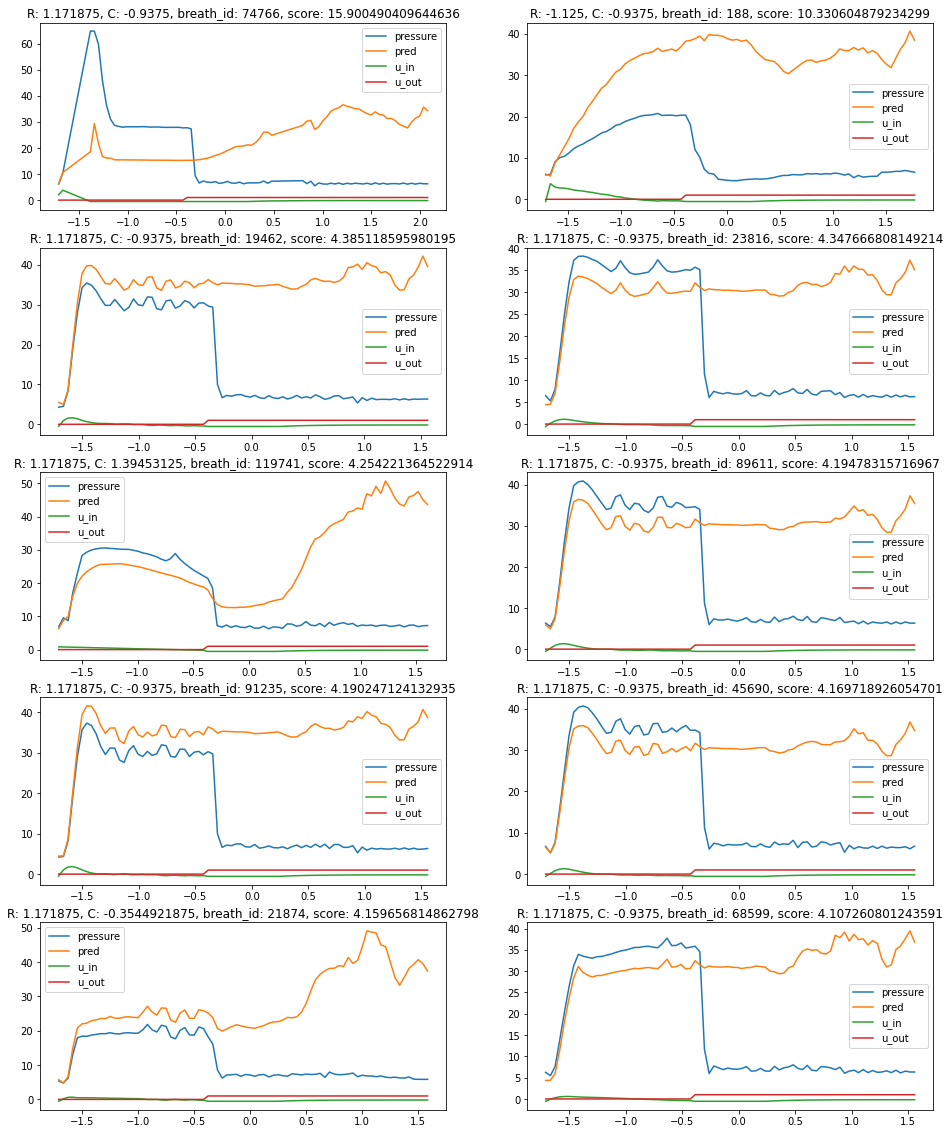

In [36]:
fig, ax = plt.subplots(5, 2, figsize=(16, 20))
worth_scores = []
for i in range(10):
    score = scores[scores_sorted_idx[i]]
    breath_id = breath_ids[scores_sorted_idx[i]]
    tmp_df = val_df[val_df['breath_id'] == breath_id].reset_index(drop=True)
    worth_scores.append((tmp_df['pressure'] - tmp_df['pred']).values)
#     peaks = find_peaks(tmp_df['u_in'], distance=5)[0]

    R = tmp_df.iloc[0, 2]
    C = tmp_df.iloc[0, 3]
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['pressure'], label='pressure')
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['pred'], label='pred')
#     ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['u_in_cumsum'] * (np.max(tmp_df['pressure'])) / (np.max(tmp_df['u_in_cumsum'])), label='u_in_cumsum')
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['u_in'], label='u_in')
    ax[int(i/2)][int(i%2)].plot(tmp_df['time_step'], tmp_df['u_out'], label='u_out')
#     ax[int(i/2)][int(i%2)].scatter(tmp_df['time_step'][peaks], tmp_df['u_in'][peaks], c='red')
    ax[int(i/2)][int(i%2)].set_title(f'R: {R}, C: {C}, breath_id: {breath_id}, score: {score}')
    ax[int(i/2)][int(i%2)].legend()

    # plt.savefig('bad_score.png')

In [42]:
tgt = train[train['breath_id'] == breath_ids[scores_sorted_idx[0]]].reset_index(drop=True)
tgt

,id,breath_id,R,C,time_step,u_in,u_out,pressure
0,3588081,74766,50,10,0.000000,34.916693,0,6.189002
1,3588082,74766,50,10,0.031681,58.400839,0,10.266527
2,3588083,74766,50,10,0.248523,0.000000,0,64.820992
3,3588084,74766,50,10,0.280367,0.000000,0,64.820992
4,3588085,74766,50,10,0.312022,0.000000,0,59.759237
...,...,...,...,...,...,...,...,...
75,3588156,74766,50,10,2.772686,4.991972,1,6.470211
76,3588157,74766,50,10,2.804277,4.993145,1,6.118700
77,3588158,74766,50,10,2.835921,4.994148,1,6.470211
78,3588159,74766,50,10,2.867527,4.995003,1,6.259305


100%|██████████| 6/6 [00:00<00:00, 111.48it/s]

get_raw_features  0.001[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


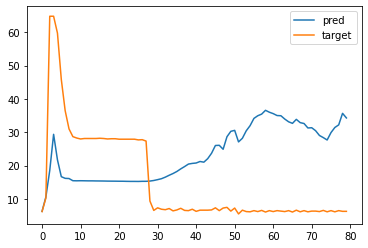

In [56]:
tgt['R'] = 50
tgt['C'] = 10

tgt_df = to_feature(tgt, dataType = 'train')

tgt_category = tgt_df[train_category_col]
tgt_df = pd.DataFrame(ss.transform(tgt_df[train_value_col]), columns=train_value_col)
tgt_df = tgt_df.fillna(train_mean)

tgt_df = pd.concat([tgt_df, tgt_category, tgt[['id', 'breath_id', 'u_out']]], axis=1)
tgt_df = utils.reduce_mem_usage(tgt_df)

tgt_value = torch.tensor(tgt_df[train_value_col].values.astype(np.float32).reshape(1, 80, -1)).to(device)
tgt_cate = torch.tensor(tgt_df[train_category_col].values.astype(int).reshape(1, 80, -1)).to(device)

tgt_pred = model(tgt_value, tgt_cate)

tgt['pred'] = to_np(tgt_pred).reshape(-1)

plt.plot(to_np(tgt_pred).reshape(-1), label = 'pred')
plt.plot(tgt['pressure'].values, label='target')
plt.legend()

In [308]:
range_ = np.arange(1, 25)/10

In [347]:
scores_df = []
for id_ in scores_sorted_idx[:100]:
    scores_tgt = []
    for i in range_:

        tgt = train[train['breath_id'] == breath_ids[id_]].reset_index(drop=True)
        tgt['u_in'] = tgt['u_in']  / i

        tgt_df = to_feature(tgt, dataType = 'train')

        tgt_category = tgt_df[train_category_col]
        tgt_df = pd.DataFrame(ss.transform(tgt_df[train_value_col]), columns=train_value_col)
        tgt_df = tgt_df.fillna(train_mean)

        tgt_df = pd.concat([tgt_df, tgt_category, tgt[['id', 'breath_id', 'u_out']]], axis=1)
        tgt_df = utils.reduce_mem_usage(tgt_df)

        tgt_value = torch.tensor(tgt_df[train_value_col].values.astype(np.float32).reshape(1, 80, -1)).to(device)
        tgt_cate = torch.tensor(tgt_df[train_category_col].values.astype(int).reshape(1, 80, -1)).to(device)

        tgt_pred = model(tgt_value, tgt_cate)

        tgt['pred'] = to_np(tgt_pred).reshape(-1)

        score = np.mean(abs(tgt[tgt['u_out']==0]['pressure'] - tgt[tgt['u_out']==0]['pred']))
        scores_tgt.append(score)
        
    scores_tgt = np.array(scores_tgt)
    scores_df.append([id_, scores[id_], np.min(scores_tgt), range_[np.argmin(scores_tgt)], np.max(tgt['u_in']), np.median(tgt['u_in']), tgt['R'][0]])
    


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.09it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.20it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.63it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.06it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.02it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.66it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.99it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 93.50it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.010[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.88it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.34it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.69it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.82it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 93.99it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.93it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.69it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.35it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.25it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.79it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.97it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.68it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.34it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.03it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.38it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.31it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.38it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.22it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 97.24it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.53it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.11it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.003[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.82it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.20it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 115.29it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.83it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.73it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.77it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.40it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.01it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.08it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.23it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.19it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 114.57it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.11it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.64it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.69it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.97it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.005[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.86it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.79it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.84it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.10it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.73it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.22it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 105.84it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.75it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 96.81it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.15it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.54it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.41it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.33it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.003[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.13it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.91it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]

  0%|          | 0/6 [00:00<?, ?it/s]


get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.90it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 97.87it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.03it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.02it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.39it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.84it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 96.85it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.47it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.73it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.19it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.38it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.010[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.36it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.78it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.15it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.27it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.015[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.41it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.71it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.90it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.22it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 115.26it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.08it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.49it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.34it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.86it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.25it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.28it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.87it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.39it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.02it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.55it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.02it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.52it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.64it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.010[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.85it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.61it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.11it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.24it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.47it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.28it/s]

get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.41it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.61it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.74it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.97it/s]

get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.92it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.34it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.77it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.37it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.14it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.07it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.54it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.005[s]


100%|██████████| 6/6 [00:00<00:00, 115.45it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.03it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.10it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.68it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.015[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 105.76it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.76it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.64it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



 67%|██████▋   | 4/6 [00:00<00:00, 22.12it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.176[s]
get_cum_features  0.002[s]


100%|██████████| 6/6 [00:00<00:00, 115.80it/s]


get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 97.56it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 104.24it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.27it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.37it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 97.81it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.84it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 105.17it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.13it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.99it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.69it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 105.56it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.06it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.54it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 97.89it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.28it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 104.82it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.34it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.003[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.44it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.05it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.002[s]


100%|██████████| 6/6 [00:00<00:00, 108.68it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.36it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.42it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.37it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.88it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.27it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.16it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.04it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.56it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 116.60it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.76it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.56it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.005[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.40it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.90it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 108.49it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.77it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.41it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.84it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.29it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 108.94it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.78it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.62it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.91it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.09it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]


  0%|          | 0/6 [00:00<?, ?it/s]

get_simple_calc_features  0.010[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.45it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.70it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.30it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.38it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.26it/s]

get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.61it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.36it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.22it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 93.28it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.051[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.64it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.62it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.86it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.98it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 96.41it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.52it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.64it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.05it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.002[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.52it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 93.10it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.018[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.36it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.71it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.85it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.49it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 115.85it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.55it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.79it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.91it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.75it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 116.00it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.42it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.005[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.62it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.74it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]

  0%|          | 0/6 [00:00<?, ?it/s]


get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.28it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.34it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.61it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.09it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.45it/s]

get_diff_shift_features  0.052[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.43it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 107.78it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 92.85it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.90it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.50it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.87it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.23it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 96.85it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.42it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.89it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.51it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.25it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 98.82it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.61it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.03it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.88it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.80it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.57it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.07it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.84it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.002[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.39it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.09it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.70it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.83it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.05it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.95it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.10it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.42it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 109.54it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.27it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.52it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.45it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.11it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.41it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.86it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.55it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.97it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.23it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.54it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.10it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.41it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.11it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.91it/s]

get_diff_shift_features  0.176[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.37it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.97it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 106.77it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.72it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.77it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.23it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.21it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 98.51it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.88it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.76it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.26it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.63it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]


  0%|          | 0/6 [00:00<?, ?it/s]

get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.24it/s]

get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.04it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.20it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 105.34it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.78it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.08it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.53it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.15it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 99.52it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.002[s]


100%|██████████| 6/6 [00:00<00:00, 115.91it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.90it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.94it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.49it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.17it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.93it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.005[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.08it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.43it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.48it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.50it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.75it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.005[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 109.56it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.70it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 112.96it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.50it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.29it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.20it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.17it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.02it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.39it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.79it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.62it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.98it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.77it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.45it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.011[s]
get_simple_calc_features  0.002[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.38it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.32it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.32it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.41it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.35it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.78it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.49it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.005[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.48it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.91it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.19it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.31it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.76it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.009[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 109.51it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.07it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.95it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.02it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.80it/s]

get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.18it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.49it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.88it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.08it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.54it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.73it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.69it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.57it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.69it/s]

get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.93it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.41it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.09it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 99.11it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.08it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.44it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.49it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.70it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.87it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.78it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.12it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 99.23it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.88it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 109.55it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.69it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.94it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 117.80it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 109.38it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.36it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.37it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.41it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]


  0%|          | 0/6 [00:00<?, ?it/s]

get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.60it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.60it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.95it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.00it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.23it/s]

get_diff_shift_features  0.049[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.12it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.48it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.50it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.05it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.02it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.97it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.66it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.78it/s]

get_diff_shift_features  0.051[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.11it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.56it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.38it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.96it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.005[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.80it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.73it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.12it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.99it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.12it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.86it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.37it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.13it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.005[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 116.70it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]


  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.050[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.35it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.05it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.46it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.09it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.37it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (75.2% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.01it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.26it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.46it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.003[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.001[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.92it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.38it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.47it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.96it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.61it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.015[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.53it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.64it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.55it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.55it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.002[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


100%|██████████| 6/6 [00:00<00:00, 113.90it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 120.03it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.42it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.42it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.46it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.90it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.14it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.11it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.52it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.85it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.49it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.79it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.02it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 100.54it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.43it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.52it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.85it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.18it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.89it/s]

get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.22it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.85it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.99it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.88it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.98it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.42it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.40it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.37it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.002[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.07it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 110.20it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.07it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.32it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.67it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 118.81it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.046[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.18it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.49it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.90it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.05it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.29it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.15it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 111.14it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.06it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.32it/s]

get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.037[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.50it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 119.21it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.005[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.80it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.82it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.05it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.04it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.003[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 108.45it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.61it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.25it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.24it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.05it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.10it/s]

get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.54it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.47it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.22it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 109.68it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.46it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.002[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.63it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.68it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.60it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.005[s]


100%|██████████| 6/6 [00:00<00:00, 117.16it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.27it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.28it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.28it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 107.83it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.005[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.24it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.74it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.24it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.005[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.82it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.57it/s]

get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.27it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.18it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 114.07it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.95it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.77it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.042[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.33it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.047[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.99it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.009[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.33it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.82it/s]

get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.59it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]


  0%|          | 0/6 [00:00<?, ?it/s]

get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.043[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.53it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.005[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.28it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.20it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 118.00it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.23it/s]

get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 105.27it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 117.42it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.005[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 113.33it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.005[s]
get_agg_features  0.007[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 116.23it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.34it/s]

get_diff_shift_features  0.041[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.005[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.50it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.73it/s]

get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.89it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.002[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 113.68it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.048[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.040[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


  0%|          | 0/6 [00:00<?, ?it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.044[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.56it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.54it/s]

get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



  0%|          | 0/6 [00:00<?, ?it/s]

Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]


100%|██████████| 6/6 [00:00<00:00, 115.15it/s]

get_diff_shift_features  0.045[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]



100%|██████████| 6/6 [00:00<00:00, 116.24it/s]


Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)
get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.039[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.1% reduction)


In [348]:
scores_df = pd.DataFrame(scores_df, columns=['id', 'ori_score', 'score', 'ratio', 'u_in_max', 'u_in_median', 'R'])

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ratio', ylabel='Density'>

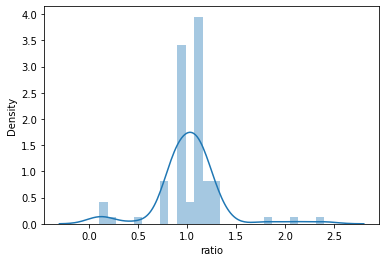

In [353]:
sns.distplot(scores_df[scores_df['R']==50]['ratio'])
sns.distplot(scores_df[scores_df['R']==50]['ratio'])

In [325]:
scores_df.corr()

,id,score,ratio,u_in_max,"u_in, median"
id,1.000000,0.254641,-0.576649,-0.217107,-0.153505
score,0.254641,1.000000,-0.599459,0.599451,-0.960703
ratio,-0.576649,-0.599459,1.000000,0.201824,0.588583
u_in_max,-0.217107,0.599451,0.201824,1.000000,-0.645568
"u_in, median",-0.153505,-0.960703,0.588583,-0.645568,1.000000


In [303]:
tgt = train[train['breath_id'] == 19462].reset_index(drop=True)
tgt['u_in'] = tgt['u_in']  / 0.2

tgt_df = to_feature(tgt, dataType = 'train')

tgt_category = tgt_df[train_category_col]
tgt_df = pd.DataFrame(ss.transform(tgt_df[train_value_col]), columns=train_value_col)
tgt_df = tgt_df.fillna(train_mean)

tgt_df = pd.concat([tgt_df, tgt_category, tgt[['id', 'breath_id', 'u_out']]], axis=1)
tgt_df = utils.reduce_mem_usage(tgt_df)

tgt_value = torch.tensor(tgt_df[train_value_col].values.astype(np.float32).reshape(1, 80, -1)).to(device)
tgt_cate = torch.tensor(tgt_df[train_category_col].values.astype(int).reshape(1, 80, -1)).to(device)

tgt_pred = model(tgt_value, tgt_cate)

tgt['pred'] = to_np(tgt_pred).reshape(-1)

score = np.mean(abs(tgt[tgt['u_out']==0]['pressure']) - abs(tgt[tgt['u_out']==0]['pred']))
score

100%|██████████| 6/6 [00:00<00:00, 117.15it/s]

get_raw_features  0.000[s]
get_category_features  0.001[s]
get_simple_calc_features  0.001[s]
get_diff_shift_features  0.038[s]
get_cum_features  0.001[s]
get_agg_features  0.006[s]
Mem. usage decreased from  0.03 Mb to  0.01 Mb (74.6% reduction)


-7.160305477403192

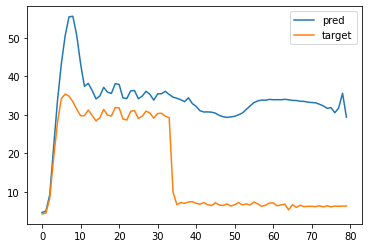

In [304]:
plt.plot(to_np(tgt_pred).reshape(-1), label = 'pred')
plt.plot(tgt['pressure'].values, label='target')
plt.legend()